# Comparaison naissance et décès

In [12]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Naissances

In [2]:
# naissance par mois
naissance_ts= pd.read_csv("data_naissance/2021-04-30_naissance.csv", index_col=0)

In [3]:
# filtre sur les années 2000
naissance_ts = naissance_ts[naissance_ts.index > '1999-12-12']
naissance_ts.index = pd.to_datetime(naissance_ts.index)

In [4]:
naissance_ts['mois'] = naissance_ts.index.month
naissance_ts['annee'] = naissance_ts.index.year

In [5]:
# extraploation

In [118]:
from sklearn import linear_model
def estimate_impact(rolling, date_min, date_max, data, label=""):
    # sample for extraploation
    roll = rolling[(rolling.index > date_min) & (rolling.index < date_max)].reset_index()
    print(roll.dtypes)
    # regression lineaire sur la période date min date max
    ######################################################
    reg = linear_model.LinearRegression()
    x = roll[['index']].copy()
    # convert datetime to ordinal
    x['index']=  x['index'].map(datetime.datetime.toordinal)
    Y = roll[[data]].copy()
    
    # make it fit
    # ----------
    reg.fit(x, Y )
    
    
    # x_extra generated through date_range
    x_extra = pd.date_range(date_min, "2021-12-31", freq="MS")
    x_extra = pd.DataFrame(x_extra)
    x_extra = x_extra[[0]].copy()
    # to ordinal for it to work
    x_extra[0] = x_extra[0].map(datetime.datetime.toordinal)
    
    # predictions
    # -----------
    y_extra = reg.predict(x_extra)
    
    
    # return a data frame
    df_ = pd.DataFrame(index=x_extra[0].map(datetime.datetime.fromordinal), data=y_extra)
    df_.columns = [label]
    df_.index.name = ""
    return df_

In [7]:
def impact_today(rolling, predict, label=""):
    last_date = rolling.index.max()
    impact = rolling.loc[last_date,:][0] - predict.loc[last_date,:][0]
    print(f"at date {last_date}, impact of COVID19 on {label} is {impact}")
    return impact

## extrapolate birth on 2020 and onward

In [8]:
# Calcul impact COVID sur les naissances

In [9]:
rolling_annual_birth = naissance_ts.rolling(12).sum()
rolling_annual_birth.drop(['annee','mois'], axis=1, inplace=True)

In [48]:
rolling_annual_birth

,naissance
2000-01-01,NaN
2000-02-01,NaN
2000-03-01,NaN
2000-04-01,NaN
2000-05-01,NaN
...,...
2020-11-01,701499.0
2020-12-01,697000.0
2021-01-01,689200.0
2021-02-01,684700.0


In [164]:
estimated_birth = estimate_impact(rolling_annual_birth, "2012-06-01", "2019-12-31", 'naissance', 'estimated_birth')

index        datetime64[ns]
naissance           float64
dtype: object


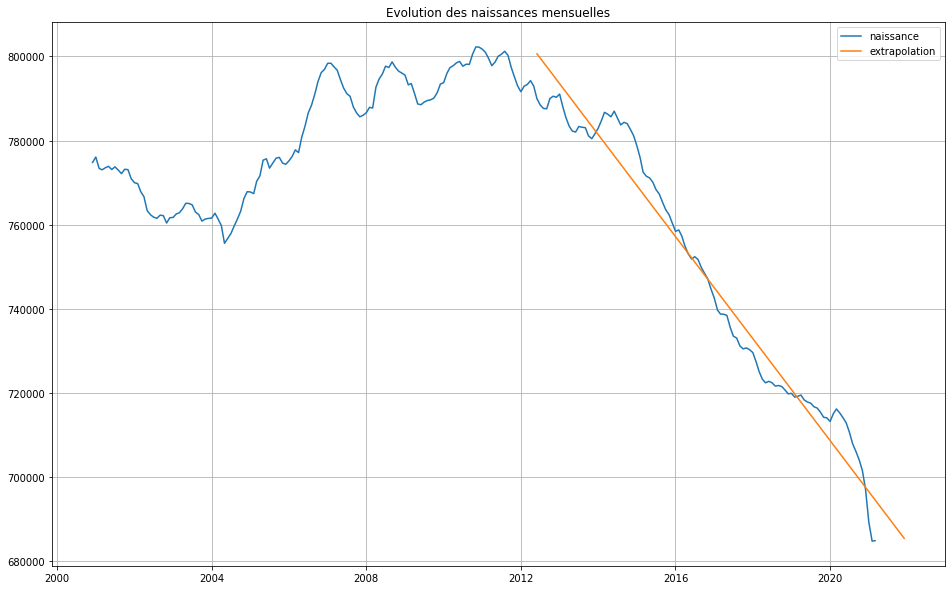

In [165]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(rolling_annual_birth['naissance'], label='naissance')
ax.plot(estimated_birth, label='extrapolation')
ax.set_title("Evolution des naissances mensuelles")

ax.legend()
ax.grid()
plt.show()

In [157]:
impact_naissance = impact_today(rolling_annual_birth, estimated_birth)

at date 2021-03-01 00:00:00, impact of COVID19 on  is -6051.073145445436


## etude sur les décés

In [65]:
# Calcul impact COVID sur les décés

In [66]:
# Données historiques en TS
# - histo_deces.csv jusqu'au 31/12/2019
# - 2020 : df_2020
# - données réa 2021 : df_2021

In [46]:
insee_file = "2021-05-07_deces_quotidiens_departement_csv.csv"
df_insee = pd.read_csv("./Data_FR_Deaths/" + insee_file, delimiter=";", index_col="Date_evenement", encoding='iso-8859-1')
df_insee.drop(["Communes_a_envoi_dematerialise_Deces2019","Total_deces_2019"],axis=1,inplace=True)
df_insee.reset_index(inplace=True)

replace_list = [('-janv.','/01/2021'),('-févr.','/02/2021'),('-mar.','/03/2021'),('-avr.','/04/2021'),('-mai','/05/2021'),('-juin','/06/2021'),('-juil.','/07/2021'),
                ('-août','/08/2021'),('-sept.','/09/2021'),('-oct.','/10/2021'),('-nov.','/11/2021'),('-déc.','/12/2021')]
for m, r in replace_list:
    df_insee['Date_evenement'].replace(to_replace=m, value = r, regex = True, inplace=True)

df_insee.set_index('Date_evenement', inplace=True)
df_insee = df_insee[df_insee["Zone"]=="France"][["Total_deces_2020","Total_deces_2021"]]
df_insee.sort_index(axis=1,inplace=True)
df_insee.columns = [2020, 2021]
df_insee

,2020,2021
Date_evenement,,
01/01/2021,1900,2140.0
02/01/2021,3795,4194.0
03/01/2021,5744,6343.0
04/01/2021,7569,8538.0
05/01/2021,9304,10712.0
...,...,...
27/12/2021,660675,NaN
28/12/2021,662849,NaN
29/12/2021,664923,NaN


In [51]:
df_2021 = pd.DataFrame(df_insee[2021])
df_2021.drop("29/02/2021", inplace=True)
df_2021 = df_2021.diff()
df_2021.loc["01/01/2021",2021]=df_insee.loc["01/01/2021",2021]
df_2021 = df_2021.reset_index()
df_2021.columns = ['index', 'nbr_deces' ]
df_2021['index'] = pd.to_datetime(df_2021['index'], dayfirst=True)
df_2021

,index,nbr_deces
0,2021-01-01,2140.0
1,2021-01-02,2054.0
2,2021-01-03,2149.0
3,2021-01-04,2195.0
4,2021-01-05,2174.0
...,...,...
360,2021-12-27,NaN
361,2021-12-28,NaN
362,2021-12-29,NaN
363,2021-12-30,NaN


In [148]:
death_ts = pd.read_csv("./Data_FR_Deaths/" + 'histo_deces.csv', index_col = 0)
# on enleve les problèmes de formatage et les données avant 2000 et avant 2020
death_ts = death_ts.filter(regex = '20[0-1][0-9]\-[0-1][0-9]\-[0-3][0-9]', axis=0)
death_ts.index = pd.DatetimeIndex(death_ts.index)
# Add info for reference
death_ts.reset_index(inplace=True)
death_ts.columns = ['index', 'nbr_deces' ]
#death_ts = death_ts[death_ts['index']<'2020-01-01']

# 2020
tmp = pd.read_csv("Data_FR_Deaths/deces_2020.csv", index_col=0, parse_dates=[0]).reset_index()
#death_ts.columns = ['index', 'nbr_deces' ]
tmp.columns =['index', 'nbr_deces' ]
death_ts= death_ts.append(tmp)
# 2021
death_ts= death_ts.append(df_2021)

# filtre sur les bonnes dates
death_ts['index'] = pd.to_datetime(death_ts['index'], dayfirst=True)
death_ts.dropna(axis=0, inplace=True)

#death_ts = death_ts[death_ts['index']<'2020-01-01']

In [149]:
death_ts

,index,nbr_deces
0,2000-01-01,1974.0
1,2000-01-02,2040.0
2,2000-01-03,2086.0
3,2000-01-04,2080.0
4,2000-01-05,2039.0
...,...,...
111,2021-04-22,1779.0
112,2021-04-23,1779.0
113,2021-04-24,1722.0
114,2021-04-25,1653.0


In [150]:
def todate(r):
    if r['mois']< 10:
        return datetime.datetime.fromisoformat(str(r['annee'])+"-0"+str(r['mois'])+"-01")
    else:
        return datetime.datetime.fromisoformat(str(r['annee'])+"-"+str(r['mois'])+"-01")

In [151]:

death_ts['mois'] = death_ts['index'].dt.month
death_ts['annee'] = death_ts['index'].dt.year
death_ts['date'] = death_ts.apply(todate, axis=1)
death_ts.drop(['annee','mois'],axis=1,inplace=True)
death_ts = death_ts.groupby(['date']).sum()

death_ts.index.name="index"

In [152]:
rolling_annual_death= death_ts.rolling(12).sum()
#rolling_annual_death= rolling_annual_death.reset_index()
#rolling_annual_death.columns = ['index','nbr_deces']
#olling_annual_birth.drop(['annee','mois'], axis=1, inplace=True)

In [153]:
rolling_annual_death.reset_index()

,index,nbr_deces
0,2000-01-01,NaN
1,2000-02-01,NaN
2,2000-03-01,NaN
3,2000-04-01,NaN
4,2000-05-01,NaN
...,...,...
251,2020-12-01,667361.0
252,2021-01-01,676660.0
253,2021-02-01,682409.0
254,2021-03-01,677587.0


In [154]:
estimated_death = estimate_impact(rolling_annual_death, "2010-01-01", "2019-12-31", "nbr_deces", 'estimated_death')

index        datetime64[ns]
nbr_deces           float64
dtype: object


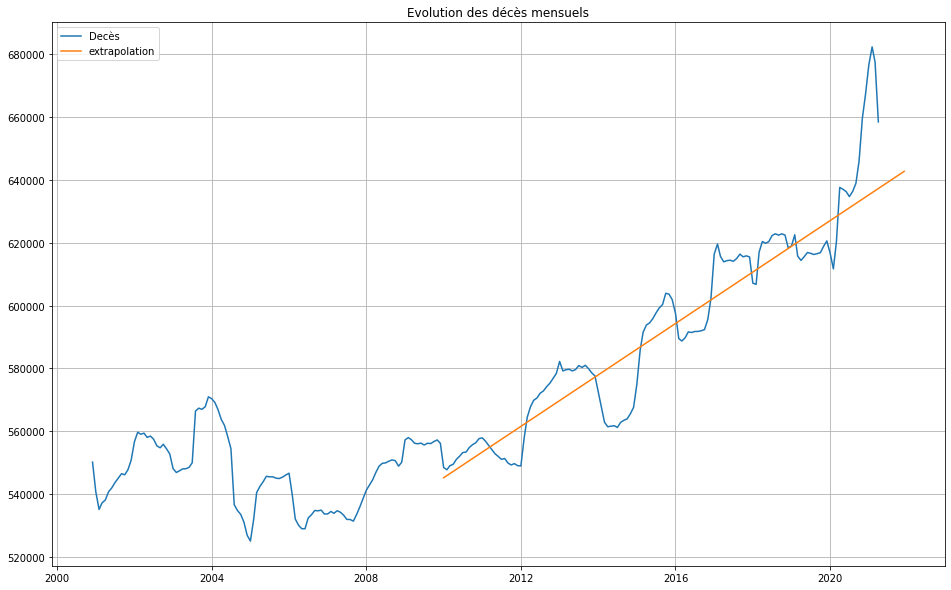

In [160]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(rolling_annual_death['nbr_deces'], label='Decès')
ax.plot(estimated_death, label='extrapolation')

ax.set_title("Evolution des décès mensuels")
ax.legend()
ax.grid()
plt.show()

In [166]:
impact_deces = impact_today(rolling_annual_death, estimated_death, "Deaths")

at date 2021-04-01 00:00:00, impact of COVID19 on Deaths is 21225.12945511192


In [168]:
# balance nette covid
print("Impact total covid à fin Avril 2021")
print("-----------------------------------")
print("Naissance : ", impact_naissance)
print("Décès : ", impact_deces)
print()
print("---------------------")
print("Impact global population : ", impact_naissance-impact_deces)

Impact total covid à fin Avril 2021
-----------------------------------
Naissance :  -6051.073145445436
Décès :  21225.12945511192

---------------------
Impact global population :  -27276.202600557357
